In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

%matplotlib inline

# Fetch data from two directories

Since we have `results_20240126/` and `results_20240131/` stored in S3 bucket, and they have overlapping `JSON` files. After some investigation, `results_20240126/` does contain some "popular" repositores that we would like to experiment on for the "popular downloaded PyPI projects". In this experiment, we just leave them as they are.

In [2]:
# Directories containing JSON files for each project
project_directory_1 = "../experiments/biomedical_projects_experiment/results_20240126/"
project_directory_2 = "../experiments/biomedical_projects_experiment/results_20240131/"

In [3]:
with open(
    "../experiments/biomedical_projects_experiment/repositories.json", "r"
) as file:
    repositories = json.load(file)

repo_names = []
for repo in repositories:
    repo_name = repo["repository"].split("/")[-1]
    repo_names.append(repo_name)

In [4]:
for filename in os.listdir(project_directory_1):
    if filename[:-5] not in repo_names:
        print(filename)
        break

In [5]:
for filename in os.listdir(project_directory_2):
    if filename[:-5] in repo_names and filename not in os.listdir(project_directory_1):
        print(filename)
        break

In [6]:
# List of import patterns to store DataFrames for each project
project_dfs_metadata = []
project_dfs_codedirs = []
project_dfs_deps = []
project_dfs_imports = []

In [7]:
# Iterate through JSON files in the directory
for filename in os.listdir(project_directory_1):

    file_path = os.path.join(project_directory_1, filename)

    # Load JSON data from the file
    with open(file_path, "r") as file:
        project_data = json.load(file)

    # Extract data from the project_data
    metadata = project_data.get("metadata", {})
    codedirs = project_data.get("code_dirs", {})
    deps_list = project_data.get("deps_file", [])
    imports_list = project_data.get("imports", [])

    metadata_list = [metadata]
    metadata_data = pd.DataFrame(metadata_list)

    project_dfs_metadata.append(metadata_data)

    # Create a list of dictionaries of code directories
    if codedirs:
        codedirs_dicts = [
            {
                "code directory": key,
                ".py count": value["py"],
                ".ipynb count": value["ipynb"],
                "count": value["total"],
            }
            for key, value in codedirs.items()
        ]
    else:
        codedirs_dicts = [
            {
                "code directory": None,
                ".py count": 0,
                ".ipynb count": 0,
                "count": 0,
            }
        ]

    # Create a DataFrame from the list of dictionaries
    codedirs_data = pd.DataFrame(codedirs_dicts)
    codedirs_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_codedirs.append(codedirs_data)

    # Create a list of dictionaries of dependency declaration files
    deps_dicts = [
        {
            "parser_choice": dep_data["parser_choice"],
            "path": dep_data["path"],
            "deps_count": dep_data["deps_count"],
            "warnings": dep_data["warnings"],
        }
        for dep_data in deps_list
        if deps_list
    ]

    if not deps_list:
        deps_dicts = [
            {
                "parser_choice": None,
                "path": None,
                "deps_count": None,
                "warnings": None,
            }
        ]

    # Create a DataFrame from the list of dictionaries
    deps_data = pd.DataFrame(deps_dicts)
    deps_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_deps.append(deps_data)

    # Create a list of dictionaries of imports
    def _process_import_data(import_data):
        import_type = list(import_data.keys())[0]
        # Combine primary alternative and alternative imports into a single alternative import type
        display_import_type = import_type.removesuffix(" (primary)")
        import_dict = {
            "import_type": display_import_type,
            "name": import_data[import_type]["name"],
            "lineno": import_data[import_type]["source"]["lineno"],
        }
        return import_dict

    imports_dicts = [_process_import_data(import_data) for import_data in imports_list]

    # Create a DataFrame from the list of dictionaries
    imports_data = pd.DataFrame(imports_dicts)
    imports_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_imports.append(imports_data)

# Combine all project DataFrames into a single DataFrame
df_metadata = pd.concat(project_dfs_metadata, ignore_index=True)
df_codedirs = pd.concat(project_dfs_codedirs, ignore_index=True)
df_deps = pd.concat(project_dfs_deps, ignore_index=True)
df_imports = pd.concat(project_dfs_imports, ignore_index=True)

# Data cleaning
There are some projects that don't have any Python code (`.py` or `.ipynb` files) at all, and they are obviously not in our scope.

In [8]:
df_codedirs_no_code = df_codedirs[df_codedirs["code directory"].isna()]
df_codedirs_no_code

,code directory,.py count,.ipynb count,count,project_name
53,None,0,0,0,cell_controller
60,None,0,0,0,Ty1_octet_itc
81,None,0,0,0,YeastTrackAnalysis
86,None,0,0,0,aligner
88,None,0,0,0,try-manubot
...,...,...,...,...,...
14050,None,0,0,0,flu_PB1flank-GFP_neut_assay
14057,None,0,0,0,KiloSort
14069,None,0,0,0,shipyard
14070,None,0,0,0,jobmaker.scif


In [9]:
df_codedirs_clean = df_codedirs[~df_codedirs["code directory"].isna()]
df_deps_clean = df_deps[
    ~df_deps["project_name"].isin(df_codedirs_no_code["project_name"])
]
df_imports_clean = df_imports[
    ~df_imports["project_name"].isin(df_codedirs_no_code["project_name"])
]

In [10]:
len(df_codedirs_clean)

13745

In [11]:
# In fact, there's no need to do `df_imports_clean` because there are no imports detected if there are no Python code :)
df_imports[df_imports["project_name"].isin(df_codedirs_no_code["project_name"])]

,import_type,name,lineno,project_name


## Clean codedirs to remove rows of `setup.py`

In [12]:
df_deps_setup_py = df_deps_clean[df_deps_clean["parser_choice"] == "setup.py"]

In [13]:
for path_to_decrement in df_deps_setup_py["path"]:
    mask = df_codedirs_clean["code directory"] == path_to_decrement
    df_codedirs_clean.loc[mask, ".py count"] -= 1
    df_codedirs_clean.loc[mask, "count"] -= 1

df_codedirs_clean = df_codedirs_clean[
    (df_codedirs_clean[".py count"] != 0) | (df_codedirs_clean["count"] == 0)
]

In [14]:
len(df_codedirs_clean)

12197

# Analysis
## Code directories

In [15]:
# Number of projects
df_codedirs_clean["project_name"].nunique()

1229

### Count of code directories
The count of code directories stands for the complexity of the project.

In [16]:
# Count of directories containing Python code per project
count_df_codedirs = (
    df_codedirs_clean.groupby("project_name").size().reset_index(name="codedirs_count")
)

In [17]:
count_df_codedirs

,project_name,codedirs_count
0,1kp,3
1,2013-khmer-counting,1
2,2018_Bacterial_Pipeline_riboseq,1
3,2018_ecoli_pathogenicity,1
4,2018koyeast,1
...,...,...
1224,xacc,26
1225,xacc-vqe,10
1226,xray-thc,1
1227,yapic,4


In [18]:
# There are some projects that have over 200 directories containing Python code
count_df_sorted = count_df_codedirs.sort_values(by="codedirs_count", ascending=False)
count_df_sorted.head()

,project_name,codedirs_count
1045,ray,618
906,osparc-simcore,389
630,galaxy,318
1047,rdkit,172
911,pandas,165


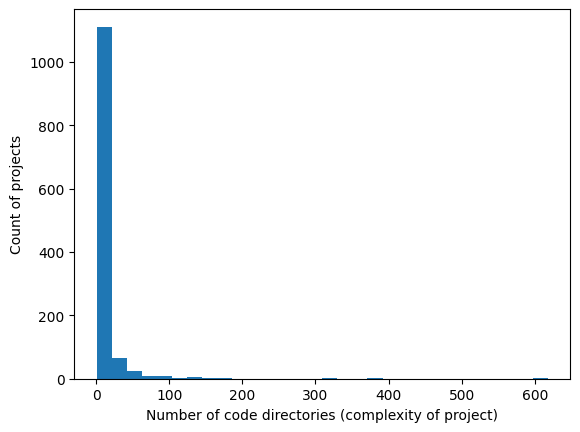

In [19]:
plt.hist(count_df_sorted["codedirs_count"], bins=30)
plt.xlabel("Number of code directories (complexity of project)")
plt.ylabel("Count of projects")
plt.show()

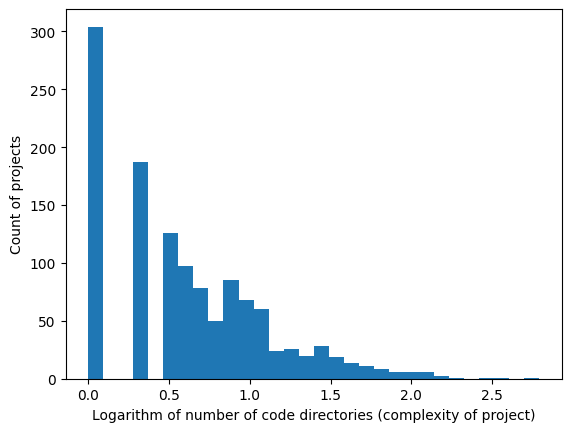

In [20]:
plt.hist(np.log10(count_df_sorted["codedirs_count"]), bins=30)
plt.xlabel("Logarithm of number of code directories (complexity of project)")
plt.ylabel("Count of projects")
plt.show()

In [21]:
count_df_sorted_truncated = count_df_sorted[count_df_sorted["codedirs_count"] < 200]

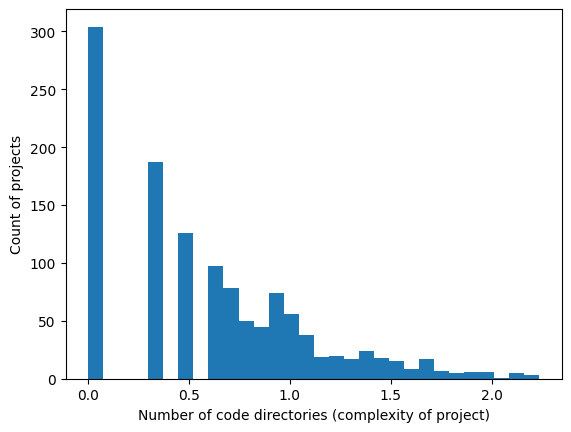

In [22]:
plt.hist(np.log10(count_df_sorted_truncated["codedirs_count"]), bins=30)
plt.xlabel("Number of code directories (complexity of project)")
plt.ylabel("Count of projects")
plt.show()

#### Example: ray

In [23]:
df_codedirs_ray = df_codedirs_clean[df_codedirs_clean["project_name"] == "ray"]

In [24]:
df_codedirs_ray

,code directory,.py count,.ipynb count,count,project_name
2688,python/ray/tests,240,0,240,ray
2689,python/ray/data/tests,68,0,68,ray
2690,python/ray/serve/tests,68,0,68,ray
2691,doc/source/ray-core/doc_code,52,0,52,ray
2692,python/ray/train/tests,52,0,52,ray
...,...,...,...,...,...
3306,release/cluster_tests/workloads,1,0,1,ray
3307,release/rllib_tests/learning_tests,1,0,1,ray
3308,python/ray/experimental/packaging/example_pkg/...,1,0,1,ray
3309,python/ray/train/examples/transformers,1,0,1,ray


Note that there might be overlaps among different groups.

In [25]:
print(
    "`python` dirs:",
    len(
        df_codedirs_ray[
            df_codedirs_ray["code directory"].str.contains("python")
            & ~df_codedirs_ray["code directory"].str.contains("test")
            & ~df_codedirs_ray["code directory"].str.contains("doc")
            & ~df_codedirs_ray["code directory"].str.contains("example")
        ]
    ),
    str(
        round(
            len(
                df_codedirs_ray[
                    df_codedirs_ray["code directory"].str.contains("python")
                    & ~df_codedirs_ray["code directory"].str.contains("test")
                    & ~df_codedirs_ray["code directory"].str.contains("doc")
                    & ~df_codedirs_ray["code directory"].str.contains("example")
                ]
            )
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
    "\n`test` dirs:",
    len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("test")]),
    str(
        round(
            len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("test")])
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
    "\n`example` dirs:",
    len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("example")]),
    str(
        round(
            len(
                df_codedirs_ray[
                    df_codedirs_ray["code directory"].str.contains("example")
                ]
            )
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
    "\n`release` dirs:",
    len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("release")]),
    str(
        round(
            len(
                df_codedirs_ray[
                    df_codedirs_ray["code directory"].str.contains("release")
                ]
            )
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
    "\n`doc` dirs:",
    len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("doc")]),
    str(
        round(
            len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("doc")])
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
    "\n`lib` dirs:",
    len(
        df_codedirs_ray[
            df_codedirs_ray["code directory"].str.contains("lib")
            & ~df_codedirs_ray["code directory"].str.contains("python")
            & ~df_codedirs_ray["code directory"].str.contains("test")
            & ~df_codedirs_ray["code directory"].str.contains("src")
        ]
    ),
    str(
        round(
            len(
                df_codedirs_ray[
                    df_codedirs_ray["code directory"].str.contains("lib")
                    & ~df_codedirs_ray["code directory"].str.contains("python")
                    & ~df_codedirs_ray["code directory"].str.contains("test")
                    & ~df_codedirs_ray["code directory"].str.contains("src")
                ]
            )
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
    "\n`src` dirs:",
    len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("src")]),
    str(
        round(
            len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("src")])
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
    "\n`dashboard` dirs:",
    len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("dashboard")]),
    str(
        round(
            len(
                df_codedirs_ray[
                    df_codedirs_ray["code directory"].str.contains("dashboard")
                ]
            )
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
    "\n`ci` dirs:",
    len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("ci")]),
    str(
        round(
            len(df_codedirs_ray[df_codedirs_ray["code directory"].str.contains("ci")])
            / len(df_codedirs_ray)
            * 100,
            2,
        )
    )
    + "%",
)

`python` dirs: 242 39.16% 
`test` dirs: 173 27.99% 
`example` dirs: 100 16.18% 
`release` dirs: 69 11.17% 
`doc` dirs: 34 5.5% 
`lib` dirs: 48 7.77% 
`src` dirs: 35 5.66% 
`dashboard` dirs: 30 4.85% 
`ci` dirs: 11 1.78%


### Main code directory

In [26]:
df_codedirs_main_code = df_codedirs_clean[
    ~df_codedirs_clean["code directory"].str.contains("test", case=False)
    & ~df_codedirs_clean["code directory"].str.contains("example", case=False)
    & ~df_codedirs_clean["code directory"].str.contains("sample", case=False)
    & (
        ~df_codedirs_clean["code directory"].str.contains("doc", case=False)
        | df_codedirs_clean["code directory"].str.contains("docker", case=False)
        | df_codedirs_clean["code directory"].str.contains("docstring", case=False)
    )
]

In [27]:
df_codedirs_max = df_codedirs_main_code.loc[
    df_codedirs_main_code.groupby("project_name")["count"].idxmax()
]

#### Note: there are some projects where the Python code are only stored in `test`, `example`, `sample`, or `doc` files.

In [28]:
xxx = df_codedirs_clean[~df_codedirs_clean["project_name"].duplicated()]
xxx[~xxx["project_name"].isin(df_codedirs_max["project_name"])]

,code directory,.py count,.ipynb count,count,project_name
412,for-app-developers/cy-automation-cy-rest-best-...,1,0,1,cytoscape-automation
523,docs,1,0,1,cy-community-detection
572,examples/python/basic/cytoscape,2,0,2,cyREST
616,hierarchical-framework-intestinal-epithelium/code,2,8,10,open-manuscripts
1189,sbml-test-suite,1,2,3,tellurium-combine-archive-test-cases
1366,testing,2,0,2,rdkit-tutorials
3396,python_tests,9,0,9,copycat-layout
4740,docs/source,1,0,1,Anima-Public
5400,docs/code,11,0,11,nix
6172,latest_notebook,1,1,2,single-cell-tutorial


In [29]:
# Divide projects into three groups by code directory patterns
same_name_projects = df_codedirs_max[
    df_codedirs_max["code directory"] == df_codedirs_max["project_name"]
]["project_name"].tolist()

src_projects = df_codedirs_max.dropna()[
    df_codedirs_max.dropna()["code directory"].str.startswith("src")
]["project_name"].tolist()

root_dir_projects = df_codedirs_max[df_codedirs_max["code directory"] == "."][
    "project_name"
].tolist()

rest_projects = df_codedirs_max[
    ~df_codedirs_max["project_name"].isin(
        same_name_projects + src_projects + root_dir_projects
    )
]["project_name"].tolist()

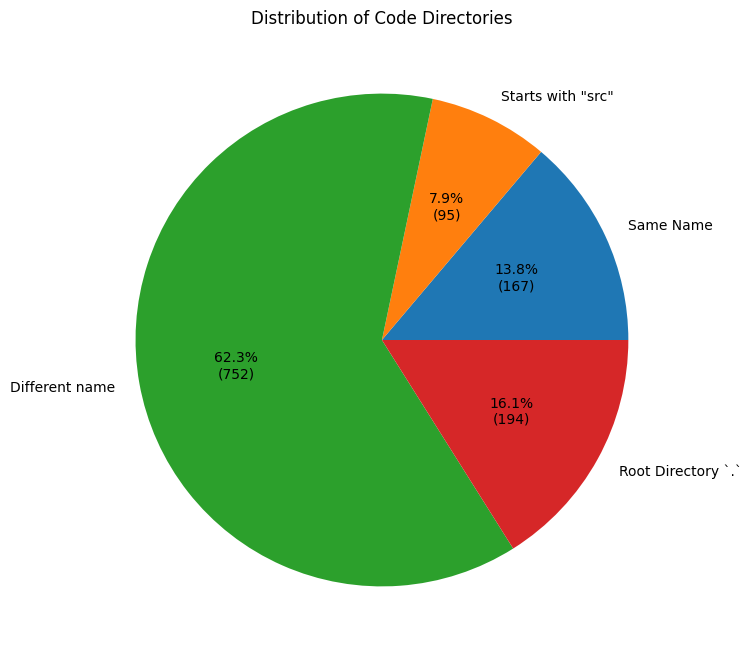

In [30]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Root Directory `.`",
        ],
        "Percentage": [
            len(same_name_projects),
            len(src_projects),
            len(rest_projects),
            len(root_dir_projects),
        ],
        "Projects": [
            same_name_projects,
            src_projects,
            rest_projects,
            root_dir_projects,
        ],
    }
)


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val)

    return my_format


# Plotting as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
    autopct=autopct_format(plot_data["Percentage"]),
)
plt.title("Distribution of Code Directories")
plt.show()

## Dependency declaration files

In [31]:
df_deps_clean

,parser_choice,path,deps_count,warnings,project_name
0,requirements.txt,test/requirements-testing.txt,8,False,darkflow
1,setup.py,setup.py,0,True,darkflow
2,setup.py,setup.py,3,False,encode2bag
3,None,None,None,None,Iterative-HMMER
4,None,None,None,None,corneal_endothelium_TVST
...,...,...,...,...,...
3308,requirements.txt,docs/docs-requirements.txt,18,False,gseapy
3309,pyproject.toml,pyproject.toml,0,False,medaka
3310,requirements.txt,requirements.txt,14,False,medaka
3311,setup.py,setup.py,0,True,medaka


In [32]:
# Divide projects into three groups by parser choice
project_req_txt = set(
    df_deps_clean[df_deps_clean["parser_choice"] == "requirements.txt"]["project_name"]
)
project_req_txt_no_deps = set(
    df_deps_clean[df_deps_clean["parser_choice"] == "requirements.txt"].loc[
        df_deps_clean["deps_count"] == 0
    ]["project_name"]
)
project_pyproject_toml = set(
    df_deps_clean[df_deps_clean["parser_choice"] == "pyproject.toml"]["project_name"]
)
project_pyproject_toml_no_deps = set(
    df_deps_clean[df_deps_clean["parser_choice"] == "pyproject.toml"].loc[
        df_deps_clean["deps_count"] == 0
    ]["project_name"]
)
project_setup = set(
    df_deps_clean.dropna()[
        df_deps_clean.dropna()["parser_choice"].str.startswith("setup")
    ]["project_name"]
)
project_no_deps = set(
    df_deps_clean[df_deps_clean["parser_choice"].isnull()]["project_name"]
)

In [33]:
project_req_only = project_req_txt - project_pyproject_toml - project_setup
project_toml_only = project_pyproject_toml - project_req_txt - project_setup
project_setup_only = project_setup - project_req_txt - project_pyproject_toml
project_req_toml = project_req_txt.intersection(
    project_pyproject_toml
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_setup = project_req_txt.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_toml_setup = project_pyproject_toml.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_toml_setup = project_req_txt.intersection(
    project_pyproject_toml
).intersection(project_setup)

In [34]:
df_deps_count = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only),
            len(project_toml_only),
            len(project_setup_only),
            len(project_req_toml),
            len(project_req_setup),
            len(project_toml_setup),
            len(project_req_toml_setup),
            len(project_no_deps),
        ],
    )
)

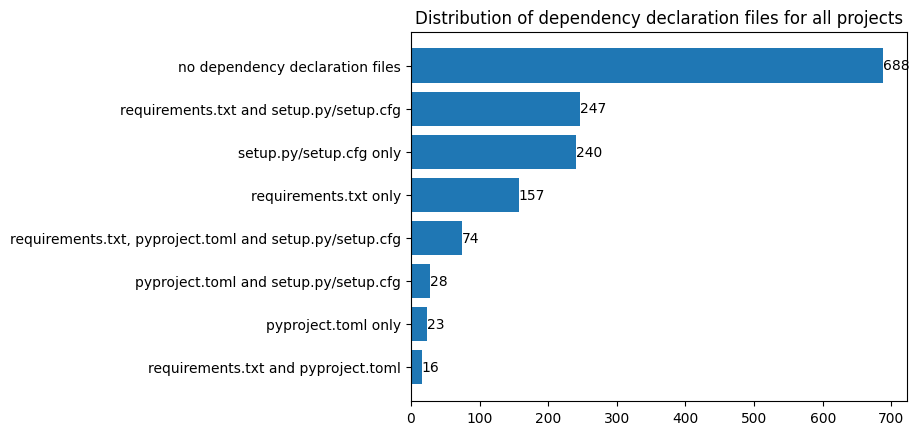

In [35]:
df_deps_count_sorted = df_deps_count.sort_values("count")
fig, ax = plt.subplots()
bars = plt.barh("type_", "count", data=df_deps_count_sorted)

ax.bar_label(bars)
plt.title("Distribution of dependency declaration files for all projects")
plt.show()

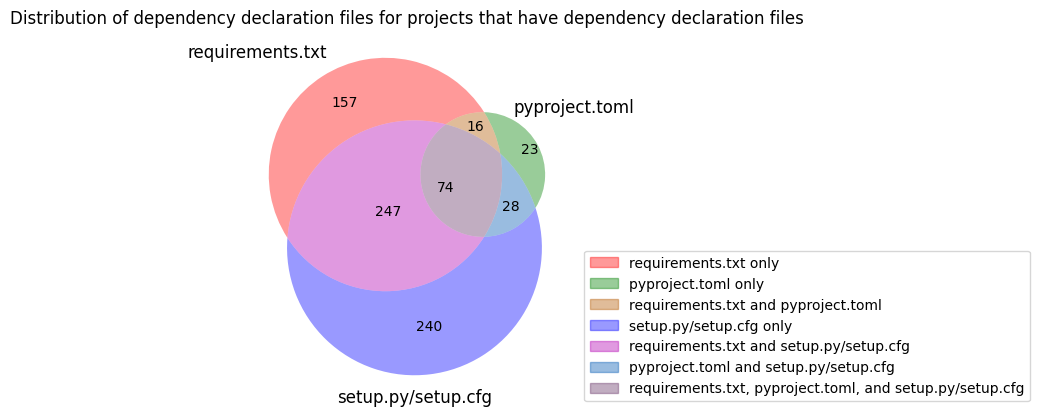

In [36]:
# Draw a venn diagram
plt.figure()
ax = plt.gca()

set_1_name = "requirements.txt"
set_2_name = "pyproject.toml"
set_3_name = "setup.py/setup.cfg"

venn_parsers = venn3(
    [project_req_txt, project_pyproject_toml, project_setup],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax,
)

# Define labels for all sets and intersections
# for a 3-circle diagram, the sequence is 100, 010, 110, 001, 101, 011, 111
legend_labels = [
    f"{set_1_name} only",
    f"{set_2_name} only",
    f"{set_1_name} and {set_2_name}",
    f"{set_3_name} only",
    f"{set_1_name} and {set_3_name}",
    f"{set_2_name} and {set_3_name}",
    f"{set_1_name}, {set_2_name}, and {set_3_name}",
]

legend_handles = [
    Patch(
        color=patch.get_facecolor(),
        label=legend_labels[venn_parsers.patches.index(patch)],
    )
    for patch in venn_parsers.patches
    if patch
]

plt.legend(handles=legend_handles, loc=(1.04, 0))
plt.title(
    "Distribution of dependency declaration files for projects that have dependency declaration files"
)
plt.show()

## Import patterns

In [37]:
df_imports_clean.head()

,import_type,name,lineno,project_name
0,Regular,numpy,2.0,darkflow
1,Regular,cv2,3.0,darkflow
2,Regular,tensorflow,1.0,darkflow
3,Regular,tensorflow,3.0,darkflow
4,Regular,numpy,4.0,darkflow


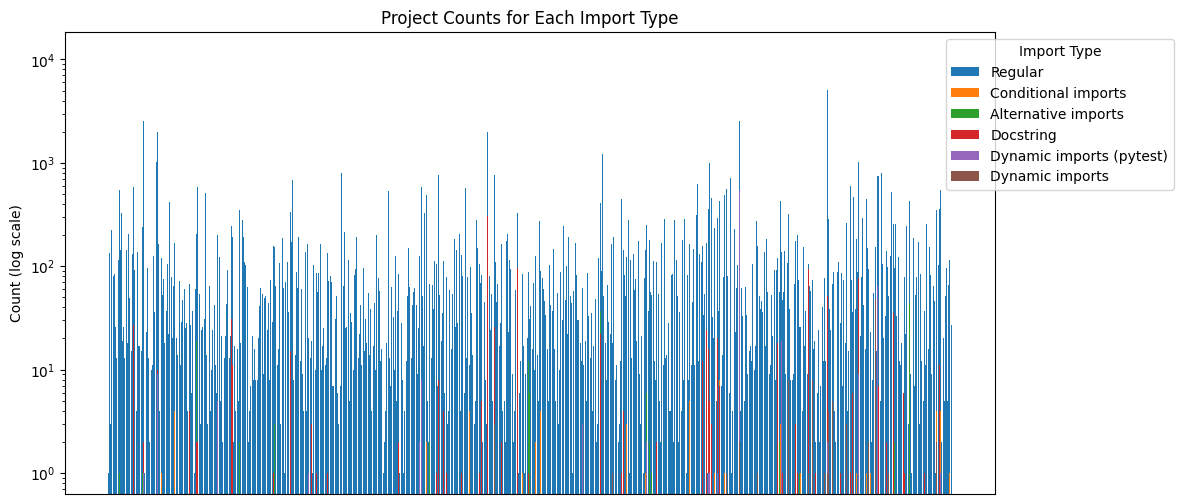

In [38]:
# Create a bar plot for the counts of each import type
frame = plt.figure(figsize=(12, 6))

# Iterate over unique import types and plot a bar for each
for import_type in df_imports_clean["import_type"].unique():
    import_type_data = df_imports_clean[df_imports_clean["import_type"] == import_type]
    project_counts = import_type_data.groupby("project_name").size()
    plt.bar(project_counts.index, project_counts, label=import_type)
    plt.yscale("log")  # Apply log scale to the y-axis for the plot
    plt.ylabel("Count (log scale)")
    plt.title("Project Counts for Each Import Type")
    plt.legend(title="Import Type", loc="upper right", bbox_to_anchor=(1.2, 1))
    # Hide x axis
    for axis in frame.axes:
        axis.get_xaxis().set_visible(False)

# Set the common x-axis label
plt.xlabel("Project Name")

plt.show()

In [39]:
# Divide projects into three groups by parser choice
project_conditional_imports = set(
    df_imports_clean[df_imports_clean["import_type"] == "Conditional imports"][
        "project_name"
    ]
)
project_alternative_imports = set(
    df_imports_clean[df_imports_clean["import_type"] == "Alternative imports"][
        "project_name"
    ]
)
project_dynamic_imports = set(
    df_imports_clean[df_imports_clean["import_type"] == "Dynamic imports"][
        "project_name"
    ]
)
project_docstring = set(
    df_imports_clean[df_imports_clean["import_type"] == "Docstring"]["project_name"]
)
project_all = set(df_codedirs_clean["project_name"])

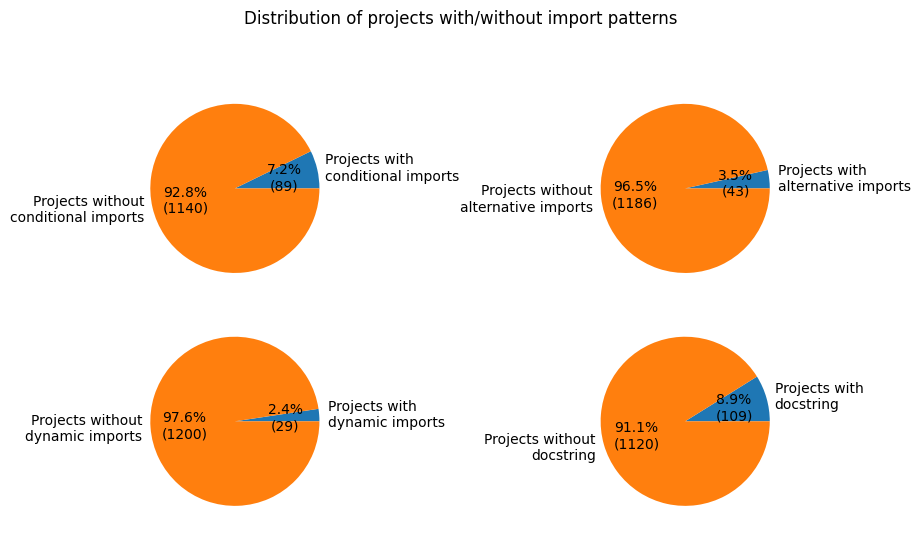

In [40]:
def create_plot_data(import_pattern, import_set):
    return pd.DataFrame(
        {
            "Category": [
                f"Projects with \n{import_pattern}",
                f"Projects without\n{import_pattern}",
            ],
            "Percentage": [
                len(import_set),
                len(project_all) - len(import_set),
            ],
        }
    )


def create_pie_chart(plot_data, axis):
    axis.pie(
        plot_data["Percentage"],
        labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
        autopct=autopct_format(plot_data["Percentage"]),
    )


figure, axis = plt.subplots(2, 2, figsize=(9, 6), layout="compressed")

create_pie_chart(
    create_plot_data("conditional imports", project_conditional_imports), axis[0, 0]
)
create_pie_chart(
    create_plot_data("alternative imports", project_alternative_imports), axis[0, 1]
)
create_pie_chart(
    create_plot_data("dynamic imports", project_dynamic_imports), axis[1, 0]
)
create_pie_chart(create_plot_data("docstring", project_docstring), axis[1, 1])

plt.suptitle("Distribution of projects with/without import patterns")
plt.show()

## Correlations

### Code directories whose names are `notebooks`

In [41]:
df_codedirs_clean[df_codedirs_clean["code directory"] == "notebooks"]

,code directory,.py count,.ipynb count,count,project_name
503,notebooks,19,17,36,CST_Lung_Cancer_Viz
550,notebooks,3,15,18,carboxecoli
1353,notebooks,1,5,6,inYourFace
1444,notebooks,6,5,11,dtrace
4879,notebooks,4,4,8,snpstr-imputation
5328,notebooks,1,7,8,gwaskb
6308,notebooks,1,2,3,hlda
7143,notebooks,1,2,3,orchid
8355,notebooks,1,5,6,lvv-ri
8374,notebooks,5,5,10,CCLE_Clustergrammer


### Count of Python files in the main code directory VS dependency declarations

In [42]:
conditions = [
    (df_codedirs_max["project_name"].isin(project_req_only)),
    (df_codedirs_max["project_name"].isin(project_toml_only)),
    (df_codedirs_max["project_name"].isin(project_setup_only)),
    (df_codedirs_max["project_name"].isin(project_req_toml)),
    (df_codedirs_max["project_name"].isin(project_req_setup)),
    (df_codedirs_max["project_name"].isin(project_toml_setup)),
    (df_codedirs_max["project_name"].isin(project_req_toml_setup)),
    (df_codedirs_max["project_name"].isin(project_no_deps)),
]

# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
    "no dependency declaration files",
]

desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
]

# create a new column and use np.select to assign values to it using our lists as arguments
df_codedirs_max["deps"] = np.select(conditions, values)

In [43]:
df_codedirs_max["deps"] = pd.Categorical(
    df_codedirs_max["deps"], categories=desired_order, ordered=True
)

In [44]:
df_codedirs_max

,code directory,.py count,.ipynb count,count,project_name,deps
13217,scripts/genealignmenttree,6,0,6,1kp,no dependency declaration files
6717,pipeline,8,0,8,2013-khmer-counting,no dependency declaration files
569,.,4,3,7,2018_Bacterial_Pipeline_riboseq,no dependency declaration files
5294,src,12,0,12,2018_ecoli_pathogenicity,no dependency declaration files
4395,src,2,0,2,2018koyeast,no dependency declaration files
...,...,...,...,...,...,...
9958,python/plugins/dwave,3,0,3,xacc,requirements.txt only
6624,benchmark,6,0,6,xacc-vqe,requirements.txt and setup.py/setup.cfg
690,analysis_notebooks,1,1,2,xray-thc,requirements.txt only
379,yapic,7,0,7,yapic,setup.py/setup.cfg only


In [45]:
df_codedirs_max[".ipynb>=5"] = np.where(
    df_codedirs_max[".ipynb count"] >= 5, True, False
)

Text(0.5, 0, 'Python code files count in the main code directory')

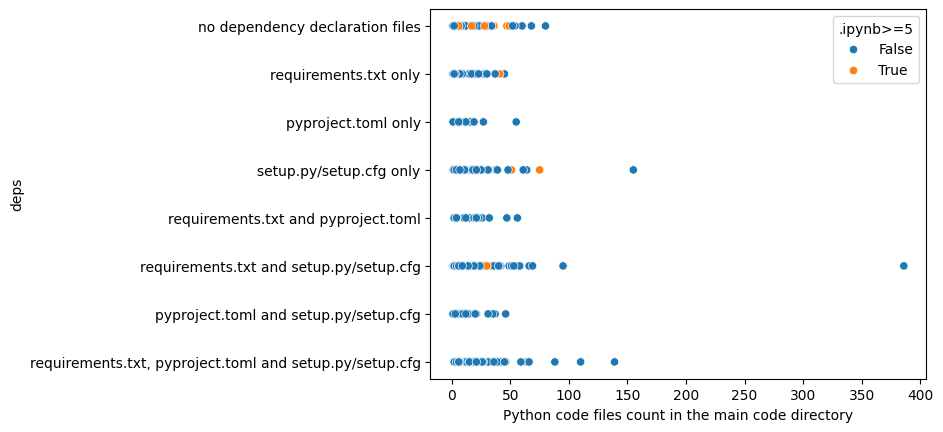

In [46]:
ax = sns.scatterplot(data=df_codedirs_max, x="count", y="deps", hue=".ipynb>=5")
ax.set_xlabel("Python code files count in the main code directory")

In [47]:
df_codedirs_max[df_codedirs_max["count"] > 100]

,code directory,.py count,.ipynb count,count,project_name,deps,.ipynb>=5
1039,cirq-core/cirq/ops,110,0,110,Cirq,"requirements.txt, pyproject.toml and setup.py/...",False
10055,sdks/python/client/argo_workflows/model,386,0,386,argo,requirements.txt and setup.py/setup.cfg,False
1577,packages/postgres-database/src/simcore_postgre...,139,0,139,osparc-simcore,"requirements.txt, pyproject.toml and setup.py/...",False
8359,scripts,155,0,155,qiime,setup.py/setup.cfg only,False


### Number of directories containing Python files VS dependency declarations

In [48]:
count_df_codedirs

,project_name,codedirs_count
0,1kp,3
1,2013-khmer-counting,1
2,2018_Bacterial_Pipeline_riboseq,1
3,2018_ecoli_pathogenicity,1
4,2018koyeast,1
...,...,...
1224,xacc,26
1225,xacc-vqe,10
1226,xray-thc,1
1227,yapic,4


In [49]:
conditions = [
    (count_df_codedirs["project_name"].isin(project_req_only)),
    (count_df_codedirs["project_name"].isin(project_toml_only)),
    (count_df_codedirs["project_name"].isin(project_setup_only)),
    (count_df_codedirs["project_name"].isin(project_req_toml)),
    (count_df_codedirs["project_name"].isin(project_req_setup)),
    (count_df_codedirs["project_name"].isin(project_toml_setup)),
    (count_df_codedirs["project_name"].isin(project_req_toml_setup)),
    (count_df_codedirs["project_name"].isin(project_no_deps)),
]

# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
    "no dependency declaration files",
]

desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
]


# create a new column and use np.select to assign values to it using our lists as arguments
count_df_codedirs["deps"] = np.select(conditions, values)

In [50]:
count_df_codedirs["deps"] = pd.Categorical(
    count_df_codedirs["deps"], categories=desired_order, ordered=True
)

In [51]:
count_df_codedirs

,project_name,codedirs_count,deps
0,1kp,3,no dependency declaration files
1,2013-khmer-counting,1,no dependency declaration files
2,2018_Bacterial_Pipeline_riboseq,1,no dependency declaration files
3,2018_ecoli_pathogenicity,1,no dependency declaration files
4,2018koyeast,1,no dependency declaration files
...,...,...,...
1224,xacc,26,requirements.txt only
1225,xacc-vqe,10,requirements.txt and setup.py/setup.cfg
1226,xray-thc,1,requirements.txt only
1227,yapic,4,setup.py/setup.cfg only


Text(0.5, 0, 'Count of directories containing Python files')

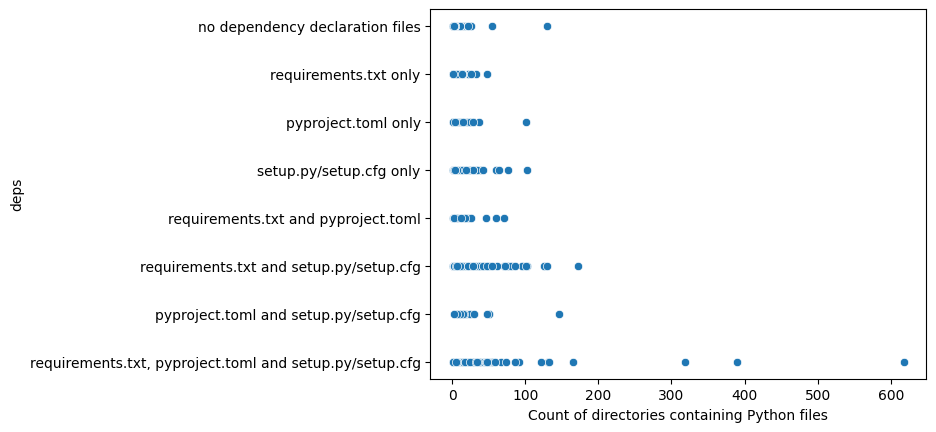

In [52]:
ax = sns.scatterplot(data=count_df_codedirs, x="codedirs_count", y="deps")
ax.set_xlabel("Count of directories containing Python files")

In [53]:
count_df_codedirs[count_df_codedirs["deps"] == "no dependency declaration files"][
    "codedirs_count"
].max()

130

In [54]:
count_df_codedirs[count_df_codedirs["codedirs_count"] == 130]

,project_name,codedirs_count,deps
773,longranger,130,no dependency declaration files
893,opencv,130,requirements.txt and setup.py/setup.cfg


In [55]:
df_metadata[df_metadata["project_name"] == "longranger"]

,project_name,fawltydeps_version,repo_url,creation_timestamp
1602,longranger,0.13.1.1,https://:@github.com/10XGenomics/longranger.git,2024-01-26T08:32:53.615111


In [56]:
df_codedirs_clean[df_codedirs_clean["project_name"] == "longranger"]

,code directory,.py count,.ipynb count,count,project_name
12235,tenkit/lib/python/tenkit,30,0,30,longranger
12236,lib/python/longranger/sv,10,0,10,longranger
12237,lib/python/longranger/test,7,0,7,longranger
12238,lib/python/longranger/cnv,6,0,6,longranger
12239,lib/python/longranger,4,0,4,longranger
...,...,...,...,...,...
12360,mro/stages/structvars/prepare_svcalling_ranges,1,0,1,longranger
12361,mro/stages/preflight/phaser_svcaller,1,0,1,longranger
12362,tenkit/mro/stages/make_fastqs/make_qc_summary,1,0,1,longranger
12363,tenkit/mro/stages/make_fastqs/merge_fastqs_by_...,1,0,1,longranger


### Correlation analysis based on Maria's FD analysis

In [57]:
# Code borrowed from Maria: https://github.com/mknorps/fd-analysis/blob/main/notebooks/analysis.ipynb

import json
import pandas as pd
import numpy as np
import seaborn as sns
import os
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Any


def filter_corrupt_files(paths: List[Path]) -> (List[Dict[str, Any]], List[str]):
    """
    Filter out files that are not valid json files
    """
    data = {}
    corrupt_files = []
    for path in paths:
        try:
            with open(path, "r") as f:
                single_result = json.load(f)
            data[path.name] = single_result
        except json.decoder.JSONDecodeError:
            corrupt_files.append(path.name)
    return data, corrupt_files


# import Zhinan's data

paths = "../experiments/biomedical_projects_experiment/results_20240126/"

data_z, corrupt_z = filter_corrupt_files(
    [Path(paths) / file for file in os.listdir(paths)]
)

codedirs = defaultdict(dict)
for d in data_z.values():
    if d["code_dirs"]:
        for folder, source_type_dict in d["code_dirs"].items():
            if folder.lower() == d["metadata"]["project_name"].lower():
                codedirs[d["metadata"]["project_name"]] |= {
                    ("PROJECT_NAME", "py"): source_type_dict["py"],
                    ("PROJECT_NAME", "ipynb"): source_type_dict["ipynb"],
                }
            else:
                codedirs[d["metadata"]["project_name"]] |= {
                    (folder, "py"): source_type_dict["py"],
                    (folder, "ipynb"): source_type_dict["ipynb"],
                }
    else:
        codedirs[d["metadata"]["project_name"]] = {}

df_codedirs = pd.DataFrame.from_dict(codedirs, orient="index")

python_projects = set(df_codedirs.index)

# Are folders specialized - either for Python files or for notebooks?

# How many subcolumns nave both nonzero values, compared to one column having zero value?

codedirs_py = df_codedirs.xs("py", level=1, axis=1)
codedirs_ipynb = df_codedirs.xs("ipynb", level=1, axis=1)

# print("Python files only")
# display(codedirs_py.head())
# print("Notebooks only")
# display(codedirs_ipynb.head())

codedirs_sum = codedirs_py + codedirs_ipynb

# print("Sum of Python files and notebooks")
# display(codedirs_sum.head())

only_py_df = (codedirs_ipynb == 0) & (codedirs_py > 0)
only_ipynb_df = (codedirs_ipynb > 0) & (codedirs_py == 0)
both_df = (codedirs_ipynb > 0) & (codedirs_py > 0)

In [58]:
conditions = [
    (codedirs_sum.index.isin(project_req_only)),
    (codedirs_sum.index.isin(project_toml_only)),
    (codedirs_sum.index.isin(project_setup_only)),
    (codedirs_sum.index.isin(project_req_toml)),
    (codedirs_sum.index.isin(project_req_setup)),
    (codedirs_sum.index.isin(project_toml_setup)),
    (codedirs_sum.index.isin(project_req_toml_setup)),
    (codedirs_sum.index.isin(project_no_deps)),
]

# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
    "no dependency declaration files",
]

desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
]


# create a new column and use np.select to assign values to it using our lists as arguments
codedirs_sum["deps"] = np.select(conditions, values)

codedirs_sum["deps"] = pd.Categorical(
    codedirs_sum["deps"], categories=desired_order, ordered=True
)

In [59]:
len(codedirs_sum)

1473

In [60]:
count_df_deps = (
    df_deps_clean.groupby("project_name").size().reset_index(name="deps_files_count")
)
display(count_df_deps)

,project_name,deps_files_count
0,1kp,1
1,2013-khmer-counting,1
2,2018_Bacterial_Pipeline_riboseq,1
3,2018_ecoli_pathogenicity,1
4,2018koyeast,1
...,...,...
1468,xacc,1
1469,xacc-vqe,2
1470,xray-thc,1
1471,yapic,1


In [61]:
codedirs_sum_deps_count = codedirs_sum.join(
    count_df_deps.set_index("project_name"), how="left"
)

<Axes: xlabel='PROJECT_NAME', ylabel='deps'>

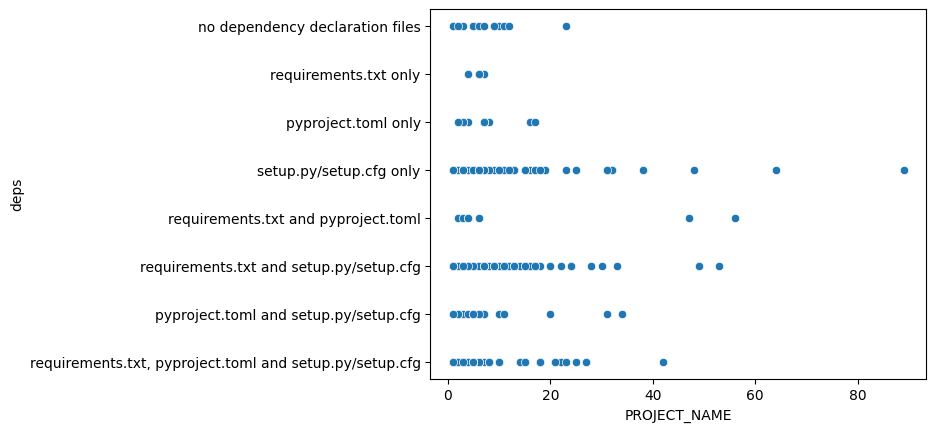

In [62]:
sns.scatterplot(x="PROJECT_NAME", y="deps", data=codedirs_sum)

<Axes: xlabel='PROJECT_NAME', ylabel='deps_files_count'>

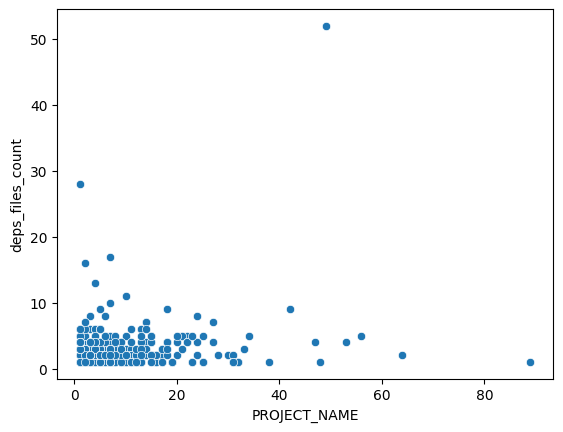

In [63]:
sns.scatterplot(x="PROJECT_NAME", y="deps_files_count", data=codedirs_sum_deps_count)

In [67]:
# Take a look at the strange point:
codedirs_sum_deps_count[codedirs_sum_deps_count["deps_files_count"] > 50][
    "PROJECT_NAME"
] > 40

gemini             True
ray               False
galaxy            False
osparc-simcore    False
Name: PROJECT_NAME, dtype: bool

In [68]:
# It has `requirements.txt` for different versions.
df_deps_clean[df_deps_clean["project_name"] == "gemini"]

,parser_choice,path,deps_count,warnings,project_name
795,requirements.txt,versioning/0.16.0/requirements_pip.txt,20,False,gemini
796,requirements.txt,versioning/0.15.0/requirements_conda.txt,0,False,gemini
797,requirements.txt,versioning/0.16.0/requirements_conda.txt,0,False,gemini
798,requirements.txt,versioning/0.9.1/requirements_conda.txt,0,False,gemini
799,requirements.txt,versioning/0.17.2/requirements_pip.txt,21,False,gemini
800,requirements.txt,versioning/0.18.2/requirements_conda.txt,8,False,gemini
801,requirements.txt,versioning/0.12.1/requirements_conda.txt,0,False,gemini
802,requirements.txt,versioning/0.16.1/requirements_conda.txt,0,False,gemini
803,requirements.txt,versioning/0.10.1/requirements_pip.txt,17,False,gemini
804,requirements.txt,versioning/0.13.0/requirements_pip.txt,17,False,gemini


In [69]:
codedirs_sum_deps_count[codedirs_sum_deps_count["PROJECT_NAME"] > 80].index

Index(['qiime'], dtype='object')

In [70]:
df_deps_clean[df_deps_clean["project_name"] == "qiime"]

,parser_choice,path,deps_count,warnings,project_name
2034,setup.py,setup.py,17,True,qiime


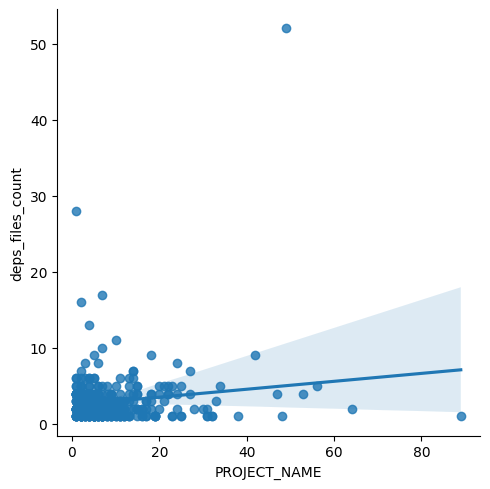

In [71]:
sns.lmplot(x="PROJECT_NAME", y="deps_files_count", data=codedirs_sum_deps_count)

In [72]:
codedirs_sum_deps_count["test-like dirs"] = codedirs_sum_deps_count.filter(
    like="test"
).sum(axis=1)

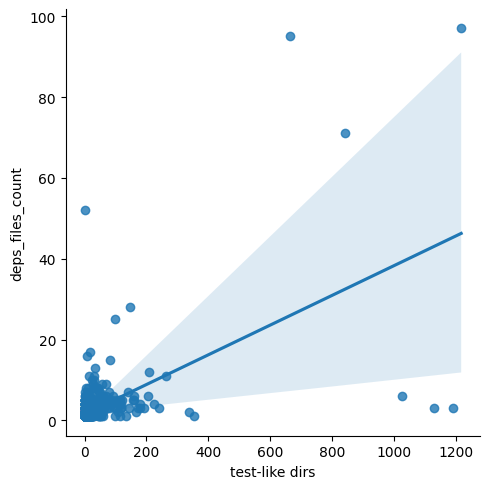

In [73]:
sns.lmplot(x="test-like dirs", y="deps_files_count", data=codedirs_sum_deps_count)

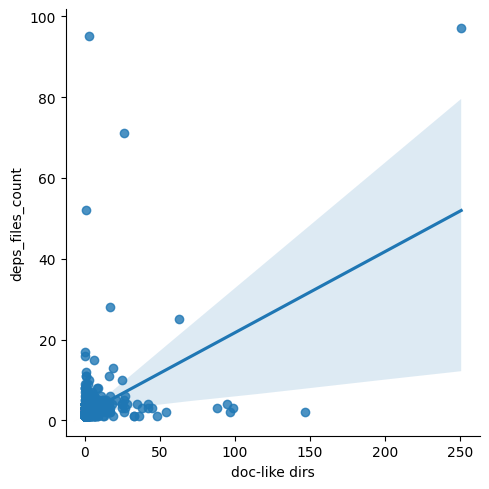

In [74]:
codedirs_sum_deps_count["doc-like dirs"] = codedirs_sum_deps_count.filter(
    like="doc"
).sum(axis=1)
sns.lmplot(x="doc-like dirs", y="deps_files_count", data=codedirs_sum_deps_count)

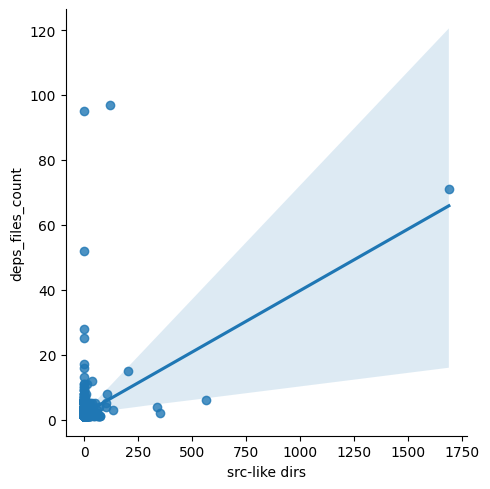

In [75]:
codedirs_sum_deps_count["src-like dirs"] = codedirs_sum_deps_count.filter(
    like="src"
).sum(axis=1)
sns.lmplot(x="src-like dirs", y="deps_files_count", data=codedirs_sum_deps_count)

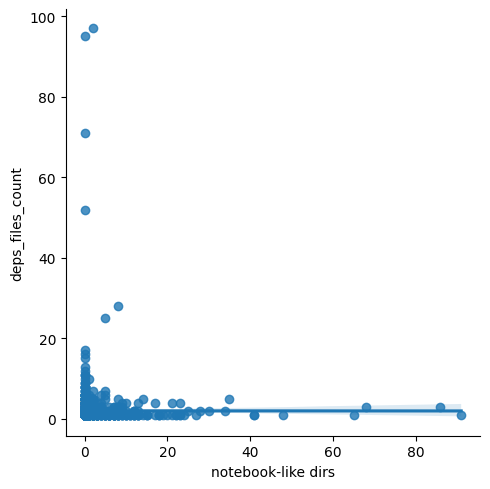

In [76]:
codedirs_sum_deps_count["notebook-like dirs"] = codedirs_sum_deps_count.filter(
    like="notebook"
).sum(axis=1)
sns.lmplot(x="notebook-like dirs", y="deps_files_count", data=codedirs_sum_deps_count)

<Axes: xlabel='notebook-like dirs', ylabel='deps'>

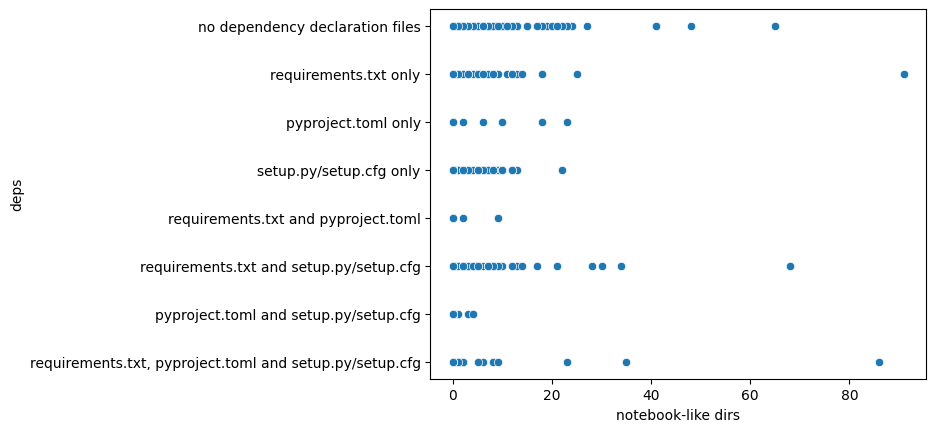

In [77]:
sns.scatterplot(x="notebook-like dirs", y="deps", data=codedirs_sum_deps_count)

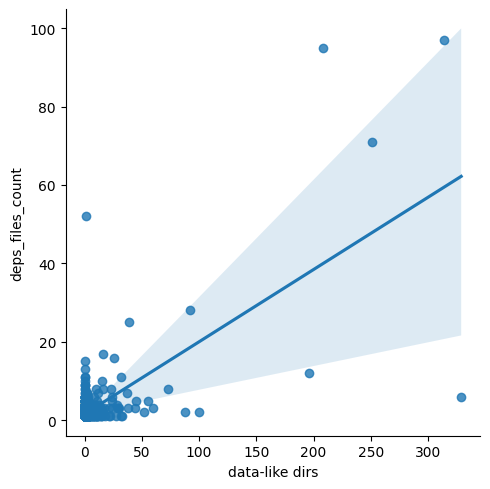

In [78]:
codedirs_sum_deps_count["data-like dirs"] = codedirs_sum_deps_count.filter(
    like="data"
).sum(axis=1)
sns.lmplot(x="data-like dirs", y="deps_files_count", data=codedirs_sum_deps_count)